# CHSH不等式の破れを確認する

この最初の実習では、量子コンピュータにおいて量子力学的状態、特に「**エンタングルメント**」が実現しているか検証してみましょう。実習を通じて量子力学の概念と量子コンピューティングの基礎を紹介していきます。

```{contents} 目次
---
local: true
---
```

$\newcommand{\ket}[1]{|#1\rangle}$
$\newcommand{\rmI}{\mathrm{I}}$
$\newcommand{\rmII}{\mathrm{II}}$
$\newcommand{\rmIII}{\mathrm{III}}$
$\newcommand{\rmIV}{\mathrm{IV}}$

## 本当に量子コンピュータなのか？

このワークブックの主旨が量子コンピュータ（QC）を使おう、ということですが、QCなんて数年前までSFの世界の存在でした。それが今やクラウドの計算リソースとして使えるというわけですが、ではそもそも私たちがこれから使おうとしている機械は本当にQCなのでしょうか。どうしたらそれが調べられるでしょうか。

QCの基本的な仕組みは、「何らかの物理的な系（超電導共振器や冷却原子など）をうまく操作して、求める計算の結果がその系の量子状態に表現されるようにする」ということです。つまり、量子状態が長く保たれてかつ思うように操作できる対象と、「計算」という実体のなさそうなものを具体的な「量子操作」に対応させるアルゴリズムの両方があって初めてQCが成り立ちます。アルゴリズムの部分はこのワークブックを通じて少しずつ紹介していくので、今回は「量子状態が保たれ、それを操作できる」ということを確認してみましょう。

## CHSH不等式

量子力学的状態が実際に存在するかどうかを確かめる実験として、2022年のノーベル物理学賞でも取り上げられたCHSH不等式{cite}`chsh`の検証というものがあります。かいつまんで言うと、CHSH不等式とは「二体系の特定の観測量について、エンタングルメントなど量子力学固有の現象がなければ保たれる不等式」です。やや回りくどいロジックですが、つまりQC（だと考えられる機械）で測ったこの観測量の値がCHSH不等式を破っていれば、その機械は実際に量子現象を利用しているかもしれないということになります。

通常このような実験を行うには高度なセットアップ（レーザーと非線形結晶、冷却原子など）が必要ですが、クラウドQCではブラウザひとつしか要りません。このワークブックではJupyter NotebookでPythonのプログラムを書き、<a href="https://quantum.ibm.com" target="_blank">IBM Quantum</a>の量子コンピュータを利用します。

## Qiskitの基本構造

IBM QuantumのQCで量子計算を実行するには、IBMの提供する<a href="https://www.ibm.com/quantum/qiskit" target="_blank">Qiskit</a>というPythonライブラリを利用します。Qiskitの基本的な使い方は

1. 使用する量子ビットの数を決め、量子計算の操作（ゲート）をかけて、量子回路を作る
1. 回路を実行して計算結果を得る。ここでは二通りのオプションがあり、
   - 回路をQCの実機に送り、実行させる。
   - 回路をシミュレートする。
1. 計算結果を解析する。

です。以下でこの流れを一通り、重要な概念の説明を混ぜながら実行してみましょう。ただし、今回は実機のみ利用します。回路のシミュレーションに関しては{doc}`第一回の課題 <nonlocal_correlations>`を参照してください。

Qiskitの機能は上のような基本的な量子回路の設計・実行だけではなく、非常に多岐に渡ります。基本的な使い方に関しても多少複雑なところがあるので、わからないことがあれば<a href="https://docs.quantum.ibm.com/" target="_blank">Qiskitのドキュメンテーション</a>をあたってみましょう。

### 量子ビット、量子レジスタ

**量子ビット**（qubit=キュビット）とは量子コンピュータの基本構成要素のことで、量子情報の入れ物の最小単位です。そして、量子ビットの集まりを量子レジスタと呼びます。

量子レジスタは量子コンピュータ中で常に一つの「状態」にあります。量子レジスタの状態を物理学の習わしに従ってしばしば「ケット」という$\ket{\psi}$のような記号で表します[^mixed_state]。量子力学に不慣れな方はこの記法で怯んでしまうかもしれませんが、ケット自体はただの記号なのであまり気にしないでください。別に「枠」なしで$\psi$と書いても、絵文字を使って🔱と書いても、何でも構いません。

重要なのは各量子ビットに対して2つの**基底状態**が定義できることで、量子計算の習わしではそれらを$\ket{0}$と$\ket{1}$で表し、「計算基底」とも呼びます[^basis]。そして、量子ビットの任意の状態は、2つの複素数$\alpha, \beta$を使って

$$
\alpha \ket{0} + \beta \ket{1}
$$

と2つの基底の「重ね合わせ」で表せます。ここで$\alpha, \beta$を確率振幅、もしくは単に**振幅**（amplitude）と呼びます。繰り返しですが別に表記法自体に深い意味はなく、例えば同じ状態を$[\alpha, \beta]$と書いてもいいわけです[^complexarray]。

量子ビットの任意の状態が2つの複素数で表せるということは、逆に言えば一つの量子ビットには2つの複素数に相当する情報を記録できるということになります。ただこれには少し注釈があって、量子力学の決まりごとから、$\alpha$と$\beta$は

$$
|\alpha|^2 + |\beta|^2 = 1
$$

という関係を満たさなければならず、かつ全体の位相（global phase）は意味を持たない、つまり、任意の実数$\theta$に対して

$$
\alpha \ket{0} + \beta \ket{1} \sim e^{i\theta} (\alpha \ket{0} + \beta \ket{1})
$$

（ここで $\sim$ は「同じ量子状態を表す」という意味）である、という制約があります。

複素数1つは実数2つで書けるので、$\alpha$と$\beta$をあわせて実数4つ分の情報が入っているようですが、2つの拘束条件があるため、実際の自由度は 4-2=2 個です。自由度の数をあらわにして量子ビットの状態を記述するときは、

$$
e^{-i\phi/2}\cos\frac{\theta}{2}\ket{0} + e^{i\phi/2}\sin\frac{\theta}{2}\ket{1}
$$

と書いたりもします。この表記法をブロッホ球表現と呼ぶこともあります。

面白くなるのは量子ビットが複数ある場合です。例えば量子ビット2つなら、それぞれに$\ket{0}, \ket{1}$の計算基底があるので、任意の状態は

$$
\alpha \ket{0}\ket{0} + \beta \ket{0}\ket{1} + \gamma \ket{1}\ket{0} + \delta \ket{1}\ket{1}
$$

と4つの複素数を使った重ね合わせになります。2つの量子ビットの基底を並べた$\ket{0}\ket{0}$のような状態が、このレジスタの計算基底ということになります。$\ket{00}$と略したりもします。

上で登場した量子力学の決まりごとはこの場合

$$
|\alpha|^2 + |\beta|^2 + |\gamma|^2 + |\delta|^2 = 1
$$

と

$$
\alpha \ket{00} + \beta \ket{01} + \gamma \ket{10} + \delta \ket{11} \sim e^{i\theta} (\alpha \ket{00} + \beta \ket{01} + \gamma \ket{10} + \delta \ket{11})
$$

となります。量子ビットがいくつあっても拘束条件は2つだけです。

つまり、量子ビット$n$個のレジスタでは、基底の数が$2^n$個で、それぞれに複素数の振幅がかかるので、実数$2 \times 2^n - 2$個分の情報が記録できることになります。これが量子計算に関して「指数関数的」という表現がよく用いられる所以です。

量子レジスタの計算基底状態の表記法としては、上に書いたようにケットを$n$個並べたり$n$個の0/1を一つのケットの中に並べたりする方法がありますが、さらにコンパクトなのが、0/1の並び（ビット列）を二進数とみなして、対応する（十進数の）数字で表現する方法です。例えば4量子ビットのレジスタで状態$\ket{0000}$と$\ket{1111}$はそれぞれ$\ket{0}$と$\ket{15}$と書けます。

ただし、ここで注意すべきなのは、左右端のどちらが「1の位」なのか事前に約束しないといけないことです。$\ket{0100}$を$\ket{4}$（右端が1の位）とするか$\ket{2}$（左端が1の位）とするかは約束次第です。このワークブックでは、Qiskitでの定義に従って、右端を1の位とします。同時に、レジスタの最初の量子ビットが1の位に対応するようにしたいので、ケットや0/1を並べて計算基底を表現するときは、右から順にレジスタの量子ビットを並べていくことにします。

Qiskitには量子レジスタオブジェクトがあり、
```{code-block} python
from qiskit import QuantumRegister
register = QuantumRegister(4, 'myregister')
```
のように量子ビット数（この場合4）と名前（`'myregister'`）を指定して初期化します。初期状態では、量子ビットはすべて$\ket{0}$状態にあります。レジスタオブジェクトはこのままではあまり使い道がなく、基本的には次に紹介する量子回路の一部として利用します。

[^mixed_state]: 正確には、状態がケットで表せるのはこのレジスタが他のレジスタとエンタングルしていないときに限られますが、ここでは詳細を割愛します。
[^basis]: ここで言う「基底」は線形代数での意味（basis）で、「線形空間中の任意のベクトルを要素の線形和で表せる最小の集合」です。基底となる量子状態だから「基底状態」と呼びます。化学や量子力学で言うところのエネルギーの最も低い状態「基底状態」（ground state）とは関係ありません。
[^complexarray]: 実際に量子計算のシミュレーションをコンピュータ上で行う時などは、量子レジスタの状態を複素数の配列で表すので、この表記の方がよく対応します。

### ゲート、回路、測定

量子計算とは、端的に言えば、量子レジスタに特定の状態を生成し、その振幅を利用することと言えます。

とは言っても、いきなり「えいや」と好きな量子状態を作れるわけではなく、パターンの決まった単純操作（$\ket{0}$と$\ket{1}$を入れ替える、ブロッホ球表現での位相角度$\phi$を増減させる、など）を順番に組み合わせて複雑な状態を作っていきます。この単純操作のオペレーションのことを一般に量子**ゲート**といい、ゲートの種類や順番を指定したプログラムに相当するものを量子**回路**と呼びます。

Qiskitでは、量子回路を`QuantumCircuit`オブジェクトで表します。
```{code-block} python
from qiskit import QuantumCircuit, QuantumRegister
register = QuantumRegister(4, 'myregister')
circuit = QuantumCircuit(register)
```
という具合です。

作られた量子回路は、量子ビットの数が決まっているもののゲートが一つもない「空っぽ」の状態なので、そこにゲートをかけていきます。例えば下で説明するアダマールゲートをレジスタの2個目の量子ビットに作用させるには
```{code-block} python
circuit.h(register[1])
```
とします。

上で「振幅を利用する」という曖昧な表現をしましたが、それはいろいろな利用の仕方があるからです。しかし、どんな方法であっても、必ず量子レジスタの**測定**という操作を行います。量子コンピュータから何かしらの情報を得るための唯一の方法が測定です。Qiskitでは`measure_all`というメソッドを使って測定を行います。
```{code-block} python
circuit.measure_all()
```

測定は量子レジスタの状態を「覗き見る」ような操作ですが、一回の測定操作で具体的に起きることは、各量子ビットに対して0もしくは1という値が得られるというだけです。つまり、量子状態が$2^n$個の計算基底の複雑な重ね合わせであったとしても、測定をすると一つの計算基底に対応するビット列が出てくるだけということになります。しかも、一度測定してしまった量子ビットはもう状態を変えてしまっていて、複雑な重ね合わせは失われてしまいます。

ではこの「一つの計算基底」がどの基底なのかというと、実は特殊な場合を除いて決まっていません。全く同じ回路を繰り返し実行して測定すると、毎回ランダムにビット列が決まります。ただし、このランダムさには法則があって、**特定のビット列が得られる確率は、対応する計算基底の振幅の絶対値自乗**となっています。つまり、$n$ビットレジスタの状態$\sum_{j=0}^{2^n-1} c_j \ket{j}$があるとき、測定でビット列$k$が得られる確率は$|c_k|^2$です。根本的には、この確率の分布$|c_0|^2, |c_1|^2, \dots, |c_{2^n-1}|^2$こそが量子計算の結果です。

### 量子計算結果の解析

回路の実行と測定を何度も繰り返して、それぞれのビット列が現れる頻度を記録すれば、だんだん$|c_j|^2$の値がわかっていきます。例えば、2量子ビットの回路を1000回実行・測定して、ビット列00、01、10、11がそれぞれ246回、300回、103回、351回得られたとすれば、統計誤差を考慮して$|c_0|^2=0.24 \pm 0.01$、$|c_1|^2=0.30 \pm 0.01$、$|c_2|^2=0.11 \pm 0.01$、$|c_3|^2=0.35 \pm 0.01$という具合です。しかし、わかるのは$c_j$の絶対値だけで、複素位相については知る術なしです。どうもすっきりしませんが、これが量子コンピュータから情報を得る方法です。

逆に、指数関数的な内部の情報量をうまく使って計算を行いつつ、測定という限定的な方法でも答えが読み出せるように工夫するのが、量子アルゴリズム設計の真髄ということになります。例えば理想的には、何か計算の答えが整数$k$であり、それを計算する回路の終状態が単純に$\ket{k}$となるようであれば、一度の測定で答えがわかる（上でいった特殊な場合に相当）わけです。単純に$\ket{k}$でなくても、重ね合わせ$\sum_{j=0}^{2^n-1} c_j \ket{j}$において$|c_k| \gg |c_{j \neq k}|$を実現できれば、数回の測定で答えが高確率でわかります。{doc}`shor`で紹介する位相推定アルゴリズムはその好例です。

一度の測定で答えがわかるケースを除いて、基本的には多数回の試行から確率分布を推定することになるので、量子回路を量子コンピュータの実機やシミュレータに送って実行させる時には必ず繰り返し数（「ショット数」と呼びます）を指定します。ショット数$S$でビット列$k$が$n_k$回得られた時、$|c_k|^2$の推定値は$z_k = n_k/S$、その統計誤差は（$S, n_k, S-n_k$が全て十分大きい場合）$\sqrt{z_k (1-z_k) / S}$で与えられます。

(common_gates)=
### よく使うゲート

IBM Q System Oneのような超電導振動子を利用した量子コンピュータでは、実際に使用できるゲートは量子ビット1つにかかるものと2つにかかるものに限定されます。しかし、それらを十分な数組み合わせれば、$n$量子ビットレジスタにおいてどのような状態も実現できることが、数学的に証明されています。

#### 1量子ビットの操作

1量子ビットの操作でよく使われるゲートには、以下のようなものがあります。（表中コードの`i`, `j`は量子ビットの番号）

```{list-table}
:header-rows: 1
* - ゲート名
  - 説明
  - Qiskitコード
* - $X$
  - $\ket{0}$と$\ket{1}$を入れ替える。
  - `circuit.x(i)`
* - $Z$
  - $\ket{1}$の振幅を$-1$倍する。
  - `circuit.z(i)`
* - $H$（アダマールゲート）
  - 計算基底それぞれに対して、以下の変形をする。
    ```{math}
    H\ket{0} = \frac{1}{\sqrt{2}} (\ket{0} + \ket{1}) \\
    H\ket{1} = \frac{1}{\sqrt{2}} (\ket{0} - \ket{1})
    ```
    （「量子状態にゲートを作用させる」ことをケットの記法で書くときは、ゲートに対応する記号をケットに左からかけます。）<br/>
    例えば状態$\ket{\psi} = \alpha\ket{0} + \beta\ket{1}$に対しては、
    ```{math}
    \begin{align}
    H\ket{\psi} & = \alpha \frac{1}{\sqrt{2}} (\ket{0} + \ket{1}) + \beta \frac{1}{\sqrt{2}} (\ket{0} - \ket{1}) \\
                & = \frac{1}{\sqrt{2}} (\alpha + \beta) \ket{0} + \frac{1}{\sqrt{2}} (\alpha - \beta) \ket{1}
    \end{align}
    ```
    となる。
  - `circuit.h(i)`
* - $R_{y}$
  - パラメータ$\theta$を取り、計算基底それぞれに対して、以下の変形をする。
    ```{math}
    R_{y}(\theta)\ket{0} = \cos\frac{\theta}{2}\ket{0} + \sin\frac{\theta}{2}\ket{1} \\
    R_{y}(\theta)\ket{1} = -\sin\frac{\theta}{2}\ket{0} + \cos\frac{\theta}{2}\ket{1}
    ```
  - `circuit.ry(theta, i)`
* - $R_{z}$
  - パラメータ$\phi$を取り、計算基底それぞれに対して、以下の変形をする。
    ```{math}
    R_{z}(\phi)\ket{0} = e^{-i\phi/2}\ket{0} \\
    R_{z}(\phi)\ket{1} = e^{i\phi/2}\ket{1}
  - `circuit.rz(phi, i)`
```

それでは、2量子ビットレジスタの第0ビットに$H, R_y, X$の順にゲートをかけて、最後に測定をする回路をQiskitで書いてみましょう。

In [5]:
%cd /Users/keimy/git/qc-workbook/source

from qiskit_ibm_runtime import QiskitRuntimeService
my_token = "a63d8eacbbb86cc7f48fb7be624f244809283d422ab805dc3dadbbbb663be404ca9117c00e2d0aaed3e70315f5cd27b78340080fad0287d571ba4d986064ff87"
service = QiskitRuntimeService.save_account(my_token, channel="ibm_quantum", overwrite=True)


/Users/keimy/git/qc-workbook/source


In [6]:
# First, import all the necessary python modules
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime.accounts import AccountNotFoundError


# qc_workbook is the original module written for this workbook
# If you encounter an ImportError, edit the environment variable PYTHONPATH or sys.path
from qc_workbook.utils import operational_backend

print('notebook ready')

notebook ready


In [7]:
circuit = QuantumCircuit(2) # You can also create a circuit by specifying the number of bits, without using a register
circuit.h(0) # In that case, directly specify the number of the quantum bit for the gate, not register[0]
circuit.ry(np.pi / 2., 0) #　θ = π/2
circuit.x(0)

# Measurement is always needed to get an output
circuit.measure_all()

print(f'This circuit has {circuit.num_qubits} qubits and {circuit.size()} operations')

This circuit has 2 qubits and 5 operations


最後のプリント文で、ゲートが3つなのにも関わらず "5 operations" と出てくるのは、各量子ビットの測定も一つのオペレーションとして数えられるからです。

量子計算に慣れる目的で、この$H, R_y(\pi/2), X$という順の操作で第0ビットに何が起こるかを辿ってみましょう。初期状態は$\ket{0}$で、ケット記法では操作は左からかけていく（ゲート操作が右から順に並ぶ）ので、$X R_y(\pi/2) H \ket{0}$を計算することになります。

$$
\begin{align}
X R_y\left(\frac{\pi}{2}\right) H \ket{0} & = X R_y\left(\frac{\pi}{2}\right) \frac{1}{\sqrt{2}}(\ket{0} + \ket{1}) \\
& = \frac{1}{\sqrt{2}} X \left[\left(\cos\left(\frac{\pi}{4}\right)\ket{0} + \sin\left(\frac{\pi}{4}\right)\ket{1}\right) + \left(-\sin\left(\frac{\pi}{4}\right)\ket{0} + \cos\left(\frac{\pi}{4}\right)\ket{1}\right)\right] \\
& = \frac{1}{\sqrt{2}} X \frac{1}{\sqrt{2}} \left[\left(\ket{0} + \ket{1}\right) + \left(-\ket{0} + \ket{1}\right)\right] \\
& = X \ket{1} \\
& = \ket{0}
\end{align}
$$

なので、結局$\ket{0}$状態に戻る操作でした。

#### 2量子ビットの操作

2量子ビットの操作は、量子ビットの超電導素子での実装の都合上、全て「制御ゲート」（controlled gates）という方式で行われます。この方式では、2つのビットのうち片方を制御（control）、もう片方を標的（target）として、制御ビットが1の時だけ標的ビットに何らかの操作がかかります。

例として、任意の1ビットゲート$U$を制御ゲート化した$C^i_j[U]$を考えます。ここで$i$が制御、$j$が標的ビットとします。ケットの添字でビットの番号を表して（reminder: 並べて書くときは右から順に番号を振ります）

$$
\begin{align}
C^i_j[U](\ket{0}_i\ket{0}_j) & = \ket{0}_i\ket{0}_j \\
C^i_j[U](\ket{0}_i\ket{1}_j) & = \ket{0}_i\ket{1}_j \\
C^i_j[U](\ket{1}_i\ket{0}_j) & = \ket{1}_iU\ket{0}_j \\
C^i_j[U](\ket{1}_i\ket{1}_j) & = \ket{1}_iU\ket{1}_j
\end{align}
$$

です。

上で紹介した頻出する1ビットゲート$X, Z, H, R_y, R_z$のうち、$H$以外は制御ゲート化バージョンもよく使われます。特に$C[X]$はCXやCNOTとも呼ばれ、量子計算の基本要素として多様されます。実際、全ての2量子ビット制御ゲートはCNOTと1量子ビットゲートの組み合わせに分解できます。

```{list-table}
:header-rows: 1
* - ゲート名
  - 説明
  - Qiskitコード
* - $C^i_j[X]$, CX, CNOT
  - ビット$i$が1である計算基底において、ビット$j$に$X$を作用させる。
  - `circuit.cx(i, j)`
* - $C^i_j[Z]$
  - ビット$i, j$が1である計算基底の符号を反転させる。
  - `circuit.cz(i, j)`
* - $C^i_j[R_{y}]$
  - パラメータ$\theta$を取り、ビット$i$が1である計算基底において、ビット$j$に$R_y$を作用させる。
  - `circuit.cry(theta, i, j)`
* - $C^i_j[R_{z}]$
  - パラメータ$\phi$を取り、ビット$i$が1である計算基底において、ビット$j$に$R_z$を作用させる。
  - `circuit.crz(phi, i, j)`
```

Qiskitで2ビットレジスタに制御ゲートを用い、計算基底$\ket{0}, \ket{1}, \ket{2}, \ket{3}$の振幅の絶対値自乗が$1:2:3:4$の比になるような状態を作ってみましょう。さらに$C^0_1[Z]$ゲートを使って$\ket{3}$だけ振幅の符号が他と異なるようにします。

In [8]:
theta1 = 2. * np.arctan(np.sqrt(7. / 3.))
theta2 = 2. * np.arctan(np.sqrt(2.))
theta3 = 2. * np.arctan(np.sqrt(4. / 3))

circuit = QuantumCircuit(2)
circuit.ry(theta1, 1)
circuit.ry(theta2, 0)
circuit.cry(theta3 - theta2, 1, 0) # C[Ry]　1が制御で0が標的
circuit.cz(0, 1) # C[Z] 0が制御で1が標的（実はC[Z]ではどちらが制御でも結果は同じ）
circuit.measure_all()

print(f'This circuit has {circuit.num_qubits} qubits and {circuit.size()} operations')

This circuit has 2 qubits and 6 operations


やや複雑ですが、また計算を追ってみましょう。まず角度$\theta_1, \theta_2, \theta_3$は定義から以下の関係を満たします。

$$
\begin{align}
R_y(\theta_1)\ket{0} & = \sqrt{\frac{3}{10}} \ket{0} + \sqrt{\frac{7}{10}} \ket{1} \\
R_y(\theta_2)\ket{0} & = \sqrt{\frac{1}{3}} \ket{0} + \sqrt{\frac{2}{3}} \ket{1} \\
R_y(\theta_3 - \theta_2)R_y(\theta_2)\ket{0} & = R_y(\theta_3)\ket{0} = \sqrt{\frac{3}{7}} \ket{0} + \sqrt{\frac{4}{7}} \ket{1}.
\end{align}
$$

したがって、

$$
\begin{align}
& C^1_0[R_y(\theta_3 - \theta_2)]R_{y1}(\theta_1)R_{y0}(\theta_2)\ket{0}_1\ket{0}_0 \\
= & C^1_0[R_y(\theta_3 - \theta_2)]\left(\sqrt{\frac{3}{10}} \ket{0}_1 + \sqrt{\frac{7}{10}} \ket{1}_1\right) R_y(\theta_2)\ket{0}_0\\
= & \sqrt{\frac{3}{10}} \ket{0}_1 R_y(\theta_2)\ket{0}_0 + \sqrt{\frac{7}{10}} \ket{1}_1 R_y(\theta_3)\ket{0}_0 \\
= & \sqrt{\frac{3}{10}} \ket{0}_1 \left(\sqrt{\frac{1}{3}} \ket{0}_0 + \sqrt{\frac{2}{3}} \ket{1}_0\right) + \sqrt{\frac{7}{10}} \ket{1}_1 \left(\sqrt{\frac{3}{7}} \ket{0}_0 + \sqrt{\frac{4}{7}} \ket{1}_0\right) \\
= & \sqrt{\frac{1}{10}} \ket{00} + \sqrt{\frac{2}{10}} \ket{01} + \sqrt{\frac{3}{10}} \ket{10} + \sqrt{\frac{4}{10}} \ket{11}
\end{align}
$$

最初の行で、ビット0と1にかかる$R_y$ゲートをそれぞれ$R_{y0}, R_{y1}$と表しました。

最後に$C[Z]$をかけると、$\ket{11}$だけ符号が反転します。

### 回路図の描き方と読み方

量子回路を可視化する方法として、「回路図」の標準的な描き方が決まっています。Qiskitでは`QuantumCircuit`オブジェクトの`draw()`というメソッドを使って自動描画できます。

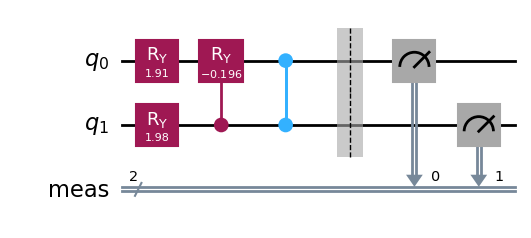

In [9]:
circuit.draw('mpl')

　ここで`draw()`の引数`'mpl'`はmatplotlibライブラリを使ってカラーで描くことを指定しています。実行環境によっては対応していないこともあるので、その場合は引数なしの`draw()`を使います。結果は`mpl`の場合に比べて見劣りしますが、内容は同じです。

In [10]:
# circuit.draw()

回路図は左から右に読んでいきます。水平の2本の実線が上からそれぞれ第0、第1量子ビットに対応し、その上にかぶさっている四角がゲート、最後にある矢印が下に伸びている箱が測定を表します。1ビットゲートから伸びている先端の丸い縦線は制御を表します。一番下の二重線は「古典レジスタ」（量子現象のない物理学を「古典物理学」と呼ぶので、量子でない通常のコンピュータにまつわる概念にはよく「古典 classical」という接頭辞をつけます）に対応し、測定結果の0/1が記録される部分です。

## CHSH不等式を計算する回路を書く

それではいよいよ本題に入りましょう。CHSH不等式を「ベル状態」$1/\sqrt{2}(\ket{00} + \ket{11})$で検証します。ベル状態は「どちらの量子ビットについても$\ket{0}$でも$\ket{1}$でもない状態」つまり、全体としては一つの定まった（純粋）状態であるにも関わらず、部分を見ると純粋でない状態です。このような時、**二つの量子ビットはエンタングルしている**といいます。エンタングルメントの存在は量子力学の非常に重要な特徴です。

ベル状態はアダマールゲートとCNOTゲートを組み合わせて作ります。詳しい説明は{doc}`課題 <nonlocal_correlations>`に譲りますが、CHSH不等式の検証用の観測量を作るために、4つの回路I, II, III, IVを使います。回路IとIIIでは量子ビット1に対し測定の直前に$R_y(-\pi/4)$、IIとIVでは同様に$R_y(-3\pi/4)$を作用させます。また回路IIIとIVでは量子ビット0に$R_y(-\pi/2)$を同じく測定の直前に作用させます。4つの回路を一度にIBMQに送るので、`circuits`というリストに回路を足していきます。

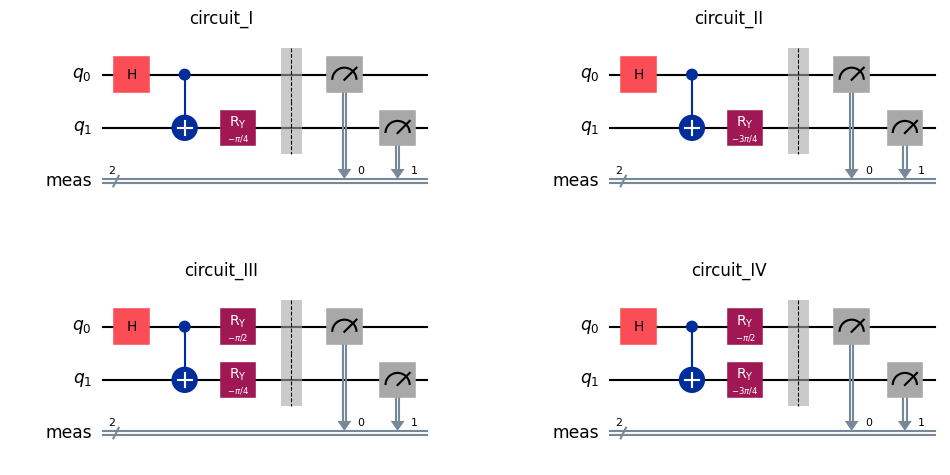

In [11]:
circuits = []

# Circuit I - H, CX[0, 1], Ry(-π/4)[1]
circuit = QuantumCircuit(2, name='circuit_I')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-np.pi / 4., 1)
circuit.measure_all()
# Append to list
circuits.append(circuit)

# Circuit II - H, CX[0, 1], Ry(-3π/4)[1]
circuit = QuantumCircuit(2, name='circuit_II')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)
circuit.measure_all()
# Append to list
circuits.append(circuit)

# Circuit III - H, CX[0, 1], Ry(-π/4)[1], Ry(-π/2)[0]
circuit = QuantumCircuit(2, name='circuit_III')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-np.pi / 4., 1)
circuit.ry(-np.pi / 2., 0)
circuit.measure_all()
# Append to list
circuits.append(circuit)

# Circuit IV - H, CX[0, 1], Ry(-3π/4)[1], Ry(-π/2)[0]
circuit = QuantumCircuit(2, name='circuit_IV')
circuit.h(0)
circuit.cx(0, 1)
circuit.ry(-3. * np.pi / 4., 1)
circuit.ry(-np.pi / 2., 0)
circuit.measure_all()
# Append to list
circuits.append(circuit)

# draw() can accept a matplotlib Axes object as an argument, to which the circuit will be drawn
# This is useful when visualizing multiple circuits from a single Jupyter cell
fig, axs = plt.subplots(2, 2, figsize=[12., 6.])
for circuit, ax in zip(circuits, axs.reshape(-1)):
    circuit.draw('mpl', ax=ax)
    ax.set_title(circuit.name)

それぞれの回路で2ビットレジスタの基底$\ket{00}, \ket{01}, \ket{10}, \ket{11}$が現れる確率を計算してみましょう。

回路Iの状態は

$$
\begin{align}
R_{y1}\left(-\frac{\pi}{4}\right) C^0_1[X] H_0 \ket{0}_1\ket{0}_0 = & R_{y1}\left(-\frac{\pi}{4}\right) \frac{1}{\sqrt{2}} (\ket{0}_1\ket{0}_0 + \ket{1}_1\ket{1}_0) \\
= & \frac{1}{\sqrt{2}} \big[(c\ket{0}_1 - s\ket{1}_1)\ket{0}_0 + (s\ket{0}_1 + c\ket{1}_1)\ket{1}_0\big]\\
= & \frac{1}{\sqrt{2}} (c\ket{00} + s\ket{01} - s\ket{10} + c\ket{11}).
\end{align}
$$

簡単のため$c = \cos(\pi/8), s = \sin(\pi/8)$とおきました。

したがって回路Iでの確率$P^{\rmI}_{l} \, (l=00,01,10,11)$は

$$
P^{\rmI}_{00} = P^{\rmI}_{11} = \frac{c^2}{2} \\
P^{\rmI}_{01} = P^{\rmI}_{10} = \frac{s^2}{2}
$$

同様に、回路IIの状態は

```{math}
:label: eqn-circuit1
R_{y1}\left(-\frac{3\pi}{4}\right) \frac{1}{\sqrt{2}} (\ket{0}_1\ket{0}_0 + \ket{1}_1\ket{1}_0) = \frac{1}{\sqrt{2}} (s\ket{00} + c\ket{01} - c\ket{10} + s\ket{11})
```

で確率$P^{\rmII}_{l}$は

$$
P^{\rmII}_{00} = P^{\rmII}_{11} = \frac{s^2}{2} \\
P^{\rmII}_{01} = P^{\rmII}_{10} = \frac{c^2}{2}
$$

です。回路IIIの状態は

$$
\begin{align}
& R_{y1}\left(-\frac{\pi}{4}\right) R_{y0}\left(-\frac{\pi}{2}\right) \frac{1}{\sqrt{2}} (\ket{0}_1\ket{0}_0 + \ket{1}_1\ket{1}_0) \\
= & \frac{1}{\sqrt{2}} \left[ \frac{1}{\sqrt{2}} (c\ket{0}_1 - s\ket{1}_1) (\ket{0}_0 - \ket{1}_0) + \frac{1}{\sqrt{2}} (s\ket{0}_1 + c\ket{1}_1) (\ket{0}_0 + \ket{1}_0) \right] \\
= & \frac{1}{2} \big[ (s+c)\ket{00} + (s-c)\ket{01} - (s-c)\ket{10} + (s+c)\ket{11} \big]
\end{align}
$$

で確率$P^{\rmIII}_{l}$は

$$
P^{\rmIII}_{00} = P^{\rmIII}_{11} = \frac{(s + c)^2}{4} \\
P^{\rmIII}_{01} = P^{\rmIII}_{10} = \frac{(s - c)^2}{4}
$$

同様に回路IVの状態と確率$P^{\rmIV}_l$は

$$
\begin{align}
& R_{y1}\left(-\frac{3\pi}{4}\right) R_{y0}\left(-\frac{\pi}{2}\right) \frac{1}{\sqrt{2}} (\ket{0}_1\ket{0}_0 + \ket{1}_1\ket{1}_0) \\
= & \frac{1}{2} \big[ (s+c)\ket{00} - (s-c)\ket{01} + (s-c)\ket{10} + (s+c)\ket{11} \big]
\end{align}
$$

$$
P^{\rmIV}_{00} = P^{\rmIV}_{11} = \frac{(s + c)^2}{4} \\
P^{\rmIV}_{01} = P^{\rmIV}_{10} = \frac{(s - c)^2}{4}
$$

となります。

それぞれの回路でビット0と1で同じ値が観測される確率$P^{i}_{00} + P^{i}_{11}$から異なる値が観測される確率$P^{i}_{01} + P^{i}_{10}$を引いた値を$C^{i}$と定義します。

$$
C^{\rmI} = c^2 - s^2 = \cos\left(\frac{\pi}{4}\right) = \frac{1}{\sqrt{2}} \\
C^{\rmII} = s^2 - c^2 = -\frac{1}{\sqrt{2}} \\
C^{\rmIII} = 2sc = \sin\left(\frac{\pi}{4}\right) = \frac{1}{\sqrt{2}} \\
C^{\rmIV} = 2sc = \frac{1}{\sqrt{2}}
$$

なので、これらの組み合わせ$S = C^{\rmI} - C^{\rmII} + C^{\rmIII} + C^{\rmIV}$の値は$2\sqrt{2}$です。

実は、エンタングルメントが起こらない場合、この観測量$S$の値は2を超えられないことが知られています。例えば$R_y$ゲートをかける前の状態がベル状態ではなく、確率$\frac{1}{2}$で$\ket{00}$、確率$\frac{1}{2}$で$\ket{11}$という「混合状態」である場合、

$$
C^{\rmI} = \frac{1}{\sqrt{2}} \\
C^{\rmII} = -\frac{1}{\sqrt{2}} \\
C^{\rmIII} = 0 \\
C^{\rmIV} = 0
$$

となり、$S = \sqrt{2} < 2$です。これがCHSH不等式です。

それでは、IBMQの「量子コンピュータ」が実際にエンタングル状態を生成できるのか、上の四つの回路から$S$の値を計算して確認してみましょう。

## 回路を実機で実行する

まずはIBM Quantumに認証・接続します。IBM Quantum Lab (IBM Quantumウェブサイト上のJupyter Lab)で実行している、もしくは自分のラップトップなどローカルの環境ですでに{ref}`認証設定が保存されている <install_token>`場合は
```{code-block} python
service = QiskitRuntimeService(channel='ibm_quantum')
```
で接続ができます。設定がない場合は`QiskitRuntimeService`のコンストラクタに{ref}`トークン <install_token>`を渡してIBM Quantumに接続します。

In [12]:
# # Specify an instance if you have access to multiple (e.g. premium access plan）
# # instance = 'hub-x/group-y/project-z'
# instance = None

# try:
#     service = QiskitRuntimeService(channel='ibm_quantum', instance=instance)
# except AccountNotFoundError:
#     service = QiskitRuntimeService(channel='ibm_quantum', token='__paste_your_token_here__', instance=instance)

In [25]:
%cd /Users/keimy/git/qc-workbook/source

from qiskit_ibm_runtime import QiskitRuntimeService

# 初回だけ
# my_token = ""
# QiskitRuntimeService.save_account(my_token, channel="ibm_quantum", overwrite=True)

service = QiskitRuntimeService()  # 保存されたアカウント情報を読み込む
print(service)

/Users/keimy/git/qc-workbook/source
<QiskitRuntimeService>


認証が済んだら、利用する量子コンピュータ（「バックエンド」と呼びます）を選びます。バックエンドで回路を実行するために、Samplerというインターフェースを使います。

In [24]:
# Find the backend that is operational and has the shortest job queue
backend = service.least_busy(filters=operational_backend())
sampler = Sampler(backend)

print(f'Jobs will run on {backend.name}')

Jobs will run on ibm_sherbrooke


回路をバックエンドに送るには、`transpile`という関数とSamplerの`run`というメソッドを使います。`transpile`については次回{ref}`transpilation`で説明するので、今は「おまじない」だと思ってください。`run`で回路を送るとき、前述したように同時にショット数を指定します。バックエンドごとに一度のジョブでの最大ショット数が決められており、8192、30000、100000などとさまざまです。回路をバックエンドに渡し、`shots`回実行させることをジョブと呼びます。

In [26]:
# max_shots = the maximum number of allowed shots for this backend with the access parameters
shots = min(backend.max_shots, 2000)
print(f'Running four circuits, {shots} shots each')

circuits = transpile(circuits, backend=backend)
# Execute each circuit for `shots` times
job = sampler.run(circuits, shots=shots)

Running four circuits, 2000 shots each


これで回路がバックエンドに送られ、キューに入りました。ジョブの実行結果は`run`メソッドの返り値であるジョブオブジェクトから参照します。

IBMQのバックエンドは世界中からたくさんのユーザーに利用されているため、場合によっては予約されているジョブが多数あってキューにかなりの待ち時間が生じることがあります。

バックエンドごとのキューの長さは<a href="https://quantum.ibm.com/services/resources" target="_blank">IBM Quantumのバックエンド一覧ページ</a>から確認できます。バックエンドを一つクリックすると詳細が表示され、現在の全ジョブ数が Total pending jobs として表示されます。また、一番下の Your access providers という欄でバックエンドのジョブあたりの最大ショット数と最大回路数を確認できます。

また、自分の投じたジョブのステータスは<a href="https://quantum.ibm.com/jobs" target="_blank">ジョブ一覧ページ</a>から確認できます。

## 量子測定結果の解析

ジョブオブジェクトの`result()`というメソッドを呼ぶと、ジョブが完了して結果が帰ってくるまでコードの実行が止まります。実行結果はオブジェクトとして返され、Samplerに渡した各回路毎にインデックスされています。回路毎のデータの`get_counts`というメソッドを使うと、各ビット列が何回観測されたかというヒストグラムデータがPythonのdictとして得られます。

In [27]:
result = job.result()

# List to collect the histogram data from the four circuits
counts_list = []

# Extracting the bit sequence counts from the result object
for idx in range(4):
    # get_counts(i) returns the histogram data for circuit i
    counts = result[idx].data.meas.get_counts()
    # Append to list
    counts_list.append(counts)

print(counts_list)

[{'00': 809, '01': 168, '11': 878, '10': 145}, {'00': 152, '01': 905, '10': 793, '11': 150}, {'11': 827, '00': 868, '01': 164, '10': 141}, {'01': 136, '11': 842, '00': 869, '10': 153}]


In [16]:
# テキスト作成用のダミーセルなので無視してよい
try:
    counts_list
except NameError:
    counts_list = [
        {'00': 3339, '01': 720, '10': 863, '11': 3270},
        {'00': 964, '01': 3332, '10': 3284, '11': 612},
        {'00': 3414, '01': 693, '10': 953, '11': 3132},
        {'00': 3661, '01': 725, '10': 768, '11': 3038}
    ]

    shots = 8192

````{tip}
ノートブックの接続が切れてしまったり、過去に走らせたジョブの結果を再び解析したくなったりした場合は、ジョブIDを使って`retrieve_job`というメソッドでジョブオブジェクトを再構成することができます。過去に走らせたジョブはIBM Quantumのホームページにリストされているので、そこにあるジョブID（cgr3kaemln50ss91pj10のような）をコピーし、

```{code-block} python
backend = provider.get_backend('__backend_you_used__')
job = backend.retrieve_job('__job_id__')
```

とすると、`backend.run`によって返されたのと同じようにジョブオブジェクトが生成されます。
````

Qiskitから提供されている`plot_histogram`関数を使って、この情報を可視化できます。プロットの縦軸は観測回数を全測定数で割って、観測確率に規格化してあります。

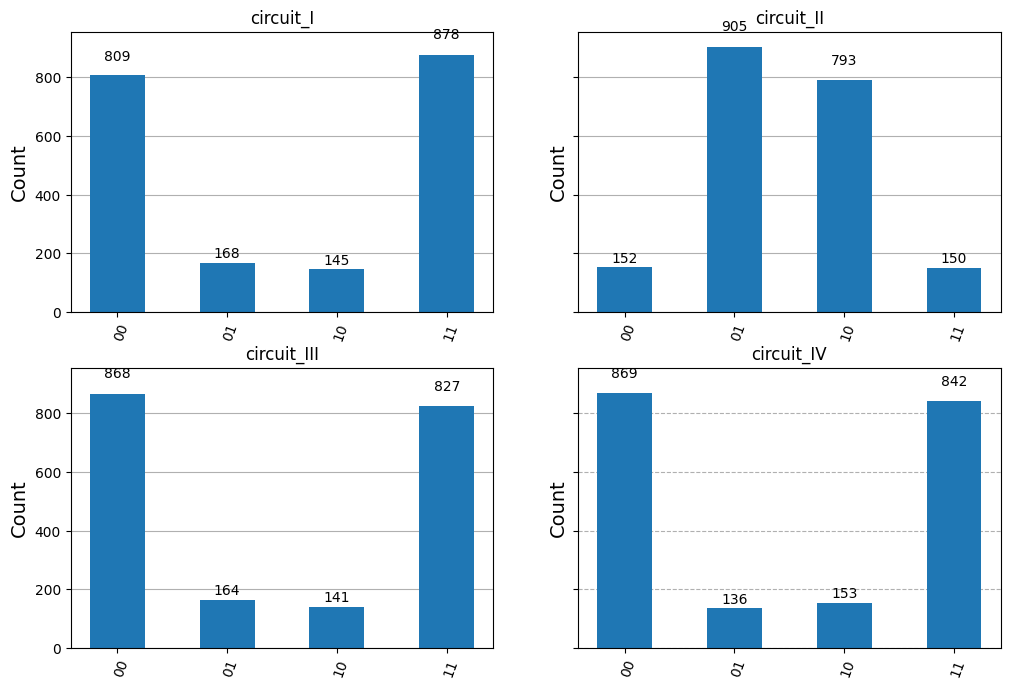

In [30]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=[12., 8.])
for counts, circuit, ax in zip(counts_list, circuits, axs.reshape(-1)):
    plot_histogram(counts, ax=ax)
    ax.set_title(circuit.name)
    ax.yaxis.grid(True)

$c^2/2 = (s + c)^2/4 = 0.427$, $s^2/2 = (s - c)^2 / 4 = 0.073$なので、得られた確率は当たらずとも遠からずというところでしょうか。

実は現在の量子コンピュータにはまだ様々なノイズやエラーがあり、計算結果は往々にして理論的な値から統計誤差の範囲を超えてずれます。特定のエラーに関しては多少の緩和法も存在しますが、全て防げるわけでは決してありません。現在の量子コンピュータを指して "*Noisy* intermediate-scale quantum (NISQ) device" と呼んだりしますが、このNoisyの部分はこのような簡単な実験でもすでに顕著に現れるわけです。

逆に、NISQデバイスを有効活用するには、ノイズやエラーがあっても意味のある結果が得られるようなロバストな回路が求められます。{doc}`vqe`で紹介する変分量子回路を用いた最適化などがその候補として注目されています。

さて、それでは最後にCHSH不等式の破れを確認してみましょう。$C^{\rmI}, C^{\rmII}, C^{\rmIII}, C^{\rmIV}$を計算して$S$を求めます。

下のコードで`counts`という辞書オブジェクトからキー`'00'`などに対応する値を取り出す際に`counts['00']`ではなく`counts.get('00', 0)`としています。二つの表現は`counts`に`'00'`というキーが定義されていれば全く同義ですが、キーが定義されていないときは、前者の場合エラーとして実行が止まるのに対して、後者ではデフォルト値として2個目の引数で指定されている`0`が返ってきます。qiskitの結果データは一度も測定されなかったビット列についてキーを持たないので、常に`get`でカウント数を抽出するようにしましょう。

In [32]:
# C^I, C^II, C^III, C^IVを一つのアレイにする
#（今の場合ただのリストにしてもいいが、純粋な数字の羅列にはnumpy arrayを使うといいことが多い）
c_arr = np.zeros(4, dtype=float)

# enumerate(L)でリストのインデックスと対応する要素に関するループを回せる
for ic, counts in enumerate(counts_list):
    # counts['00'] でなく counts.get('00', 0) - 上のテキストを参照
    c_arr[ic] = counts.get('00', 0) + counts.get('11', 0) - counts.get('01', 0) - counts.get('10', 0)

# 4つの要素を同時にshotsで規格化（リストではこういうことはできない）
c_arr /= shots

s_val = c_arr[0] - c_arr[1] + c_arr[2] + c_arr[3]

print('C:', c_arr)
print('S =', s_val)
if s_val > 2.:
    print('Yes, we are using a quantum computer!')
else:
    print('Armonk, we have a problem.')

C: [ 0.687 -0.698  0.695  0.711]
S = 2.791
Yes, we are using a quantum computer!


無事、$S$が2を超えました。